In [8]:
import tensorflow as tf
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory('F:/COMOFOD1/train',target_size=(224, 224),batch_size=20,class_mode='binary')
validation_generator = validation_datagen.flow_from_directory('F:/COMOFOD1/val',target_size=(224, 224),batch_size=20,class_mode='binary')
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('F:/COMOFOD1/test',target_size=(224, 224),batch_size=20,class_mode='binary')

Found 7004 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Flatten
from tensorflow.keras.applications import vgg16,ResNet50
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.applications.mobilenet import MobileNet
import scipy
import os
import cv2
from PIL import Image
import numpy as np
from keras.applications.resnet50 import ResNet50, preprocess_input

# proposed method

In [11]:
from sklearn.utils import class_weight
def get_model(input_shape=(224,224,3)):
  vgg=vgg16.VGG16(weights='imagenet',include_top=False,input_shape=input_shape)
  for layer in vgg.layers[:-5]:
    print(layer.name)
    layer.trainable=False
  x=vgg.output
  x=GlobalAveragePooling2D()(x)   
  #x=Dense(32)(x)
  x=Dense(1,activation="sigmoid")(x)

  model=Model(vgg.input,x)
  model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-3),metrics=["accuracy"])

  return model
model=get_model(input_shape=(224,224,3))
print(model.summary())



input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Con

In [ ]:
history = model.fit(
train_generator,
steps_per_epoch=219,
epochs=20,
validation_data=validation_generator,
validation_steps=62)

In [ ]:
#model.save('vgg16_generator_comofod.h5')

In [12]:
from tensorflow.keras.models import load_model
 
# load model
model = load_model('vgg16_generator_comofod.h5')

# image forgery detection

In [ ]:

loss,acc=model.evaluate_generator(test_generator,steps=50)
print("loss",loss,"accuracy=",(acc*100.0),"%")

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
filenames = test_generator.filenames
nb_samples = len(filenames)
predict = model.predict(test_generator,steps = nb_samples)
y_pred = np.argmax(predict, axis=1)
#y_pred = numpy.rint(predict)
y_true = test_generator.classes
print(y_pred)
print(y_true)
cm=confusion_matrix(y_true,y_pred)
print(cm)
sns.heatmap(cm,annot=True)

In [ ]:
parasited_image_idx=np.where(y_pred==1)[0]
print(parasited_image_idx)

In [ ]:
parasited_image_idx=np.where(y_pred==1)[0]
print(parasited_image_idx)
predicted_as_para=[]
for i in parasited_image_idx:
    par_img=test_generator[i][0][0]
    predicted_as_para.append(par_img)
predicted_as_para=np.array(predicted_as_para)
print(predicted_as_para)

# create heatmap on forgery image

In [ ]:
from matplotlib.patches import Rectangle
from skimage import feature
from skimage.feature.peak import peak_local_max
import cv2 as cv
def plot_heatmap(img):
  pred=model.predict(np.expand_dims(img,axis=0))
  pred_class=np.argmax(pred)
  #print(pred_class)
    
  last_layer_weights=model.layers[-1].get_weights()[0]
  #print(last_layer_weights)
  last_layer_weights_for_pred=last_layer_weights[:,pred_class]

  last_conv_model=Model(model.input,model.get_layer("block5_conv3").output)
  last_conv_output=last_conv_model.predict(img[np.newaxis,:,:,:])
  
  last_conv_output=np.squeeze(last_conv_output)
  #print(last_conv_output)


  h=int(img.shape[0]/last_conv_output.shape[0])
  w=int(img.shape[1]/last_conv_output.shape[1])
  upsampled_last_conv_output=scipy.ndimage.zoom(last_conv_output,(h,w,1),order=1)

  heat_map=np.dot(upsampled_last_conv_output.reshape((img.shape[0]*img.shape[1],512)),
                  last_layer_weights_for_pred).reshape(img.shape[0],img.shape[1])

  heat_map[img[:,:,0]==0]=0

  peak_coords=peak_local_max(heat_map,num_peaks=1,threshold_rel=0.5,min_distance=10)
  #edges1 = feature.canny(heat_map)
  #print(edges1==True)

  plt.imshow(img.astype("float32").reshape(img.shape[0],img.shape[1],3))
  plt.imshow(heat_map,cmap='jet',alpha=0.30)

  for i in range(0,peak_coords.shape[0]):
    print(i)
    y=peak_coords[i,0]
    x=peak_coords[i,1]
    print("find local max point",x,y)
    plt.gca().add_patch(Rectangle((x-25,y-25),60,60,linewidth=1,edgecolor='r',facecolor='g', alpha=0.4))
    

import random
im=random.randint(0,predicted_as_para.shape[0]-1)
print(im)
print(predicted_as_para[im].shape)
heat_map=plot_heatmap(predicted_as_para[im])


# pixel forgery detection process on one image based on heatmap and thresholding

In [13]:
test1_datagen = ImageDataGenerator(rescale=1./255)
test1_generator = test_datagen.flow_from_directory('C:/Users/zare/Desktop/y',target_size=(224, 224),batch_size=20,class_mode='binary')

Found 1 images belonging to 2 classes.


In [14]:
loss,acc=model.evaluate_generator(test1_generator,steps=50)
print("loss",loss,"accuracy=",(acc*100.0),"%")

  ...
    to  
  ['...']
loss 0.00018422681838274003 accuracy= 100.0 %


Found 7004 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 1 images belonging to 2 classes.
input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)     

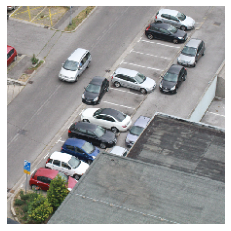

[[0.990831]]
h and w 16 16
(224, 224, 512)
0
(231, 231)
(231, 231)
Accuracy,p,r,f1,fpr,iou 0.9835189583162722 0.9995578202644656 0.9837529789659103 0.9915924258723511 0.035653650254668934 0.983325047642721
accuracy calculated!
2023-01-26 13:42:52.926942 2023-01-26 13:42:59.000804
6073


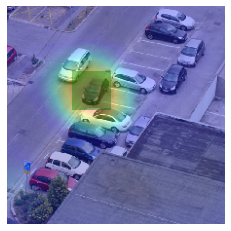

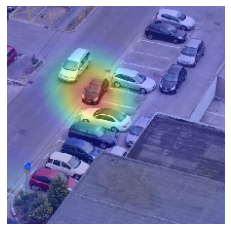

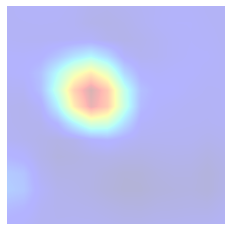

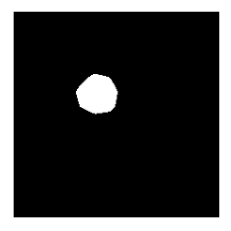

In [16]:
#calculate time
import matplotlib.pyplot as plt
import datetime
a = datetime.datetime.now()

import tensorflow as tf
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory('F:/COMOFOD1/train',target_size=(224, 224),batch_size=20,class_mode='binary')
validation_generator = test_datagen.flow_from_directory('F:/COMOFOD1/val',target_size=(224, 224),batch_size=20,class_mode='binary')

test1_datagen = ImageDataGenerator(rescale=1./255)
test1_generator = test_datagen.flow_from_directory('C:/Users/zare/Desktop/y',target_size=(224, 224),batch_size=20,class_mode='binary')

import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Flatten
from tensorflow.keras.applications import vgg16,ResNet50
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.applications.mobilenet import MobileNet
import scipy
import os
import cv2
from PIL import Image
import numpy as np
from keras.applications.resnet50 import ResNet50, preprocess_input

from sklearn.utils import class_weight
def get_model(input_shape=(224,224,3)):
  vgg=vgg16.VGG16(weights='imagenet',include_top=False,input_shape=input_shape)
  for layer in vgg.layers[:-5]:
    print(layer.name)
    layer.trainable=False
  x=vgg.output
  x=GlobalAveragePooling2D()(x)   
  #x=Dense(32)(x)
  x=Dense(1,activation="sigmoid")(x)

  model=Model(vgg.input,x)
  model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-3),metrics=["accuracy"])

  return model
model=get_model(input_shape=(224,224,3))
print(model.summary())





from tensorflow.keras.models import load_model
 
# load model
model = load_model('vgg16_generator_comofod.h5')



from matplotlib.patches import Rectangle
from skimage import feature
from skimage.feature.peak import peak_local_max
import cv2 as cv

xx,yy=test1_generator.next()
img=xx[0]
plt.figure(figsize=(4,4))
plt.axis('off')
plt.imshow(xx[0])
plt.show()

pred=model.predict_generator(test1_generator,steps =1)
print(pred)

last_layer_weights=model.layers[-1].get_weights()[0]
#print(last_layer_weights.shape)
last_layer_weights_for_pred=last_layer_weights[:,0]
#print(last_layer_weights_for_pred)

last_conv_model=Model(model.input,model.get_layer("block5_conv3").output)
#print("*******************",last_conv_model)


#print("np.newaxis",np.newaxis)
last_conv_output=last_conv_model.predict_generator(test1_generator,steps=1)
  
last_conv_output=np.squeeze(last_conv_output)
#print("last_conv_output",last_conv_output.shape)

h=16
w=16
print("h and w",h,w)
upsampled_last_conv_output=scipy.ndimage.zoom(last_conv_output,(h,w,1),order=1)
print(upsampled_last_conv_output.shape)
plt.figure(figsize=(4,4))
plt.axis('off')
plt.imshow(upsampled_last_conv_output[:,:,511])
#print("upsampled_last_conv_output",upsampled_last_conv_output.shape)
#print(last_layer_weights_for_pred.shape)
heat_map=np.dot(upsampled_last_conv_output.reshape((224*224,512)),
                  last_layer_weights_for_pred).reshape(224,224)


peak_coords=peak_local_max(heat_map,num_peaks=1,threshold_rel=0.5,min_distance=10)

plt.imshow(img.astype("float32").reshape(img.shape[0],img.shape[1],3))
plt.imshow(heat_map,cmap='jet',alpha=0.30)

for i in range(0,peak_coords.shape[0]):
    print(i)
    y=peak_coords[i,0]
    x=peak_coords[i,1]
    plt.gca().add_patch(Rectangle((x-20,y-20),40,40,linewidth=0,edgecolor='r',facecolor='g', alpha=0.4))

plt.figure(figsize=(4,4))
plt.axis('off')
plt.imshow(xx.astype("float32").reshape(224,224,3))

plt.imshow(heat_map,cmap='jet',alpha=0.30)

fig=plt.figure(figsize=(4,4))
plt.axis('off')
plt.imshow(heat_map,cmap='jet',alpha=0.30)

fig.savefig(r"C:\Users\zare\Desktop\yyyy\1\26_heatmap.png", dpi=fig.dpi)


################################################theresholding
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
pppp=r"C:\Users\zare\Desktop\yyyy\1\26_heatmap.png"
im=cv.imread(pppp)
imnew=cv.imread(pppp)
#im=cv.cvtColor(im, cv.COLOR_BGR2RGB)
im1=cv.imread(pppp)
#im1=cv.cvtColor(im1, cv.COLOR_BGR2RGB)
im3=cv.imread(pppp)
#im3=cv.cvtColor(im3, cv.COLOR_BGR2RGB)
#cv.imshow('OriginalImage',im)
b,g,r=cv.split(im)
A=np.uint8(b)
B=np.uint8(g)
C=np.uint8(r)
s=im.shape
im2=np.zeros(s,dtype=np.uint8)+0
#im2=im.copy()
im2[:,:]=0
for i in range(0,s[0]):
    for j in range(0,s[1]):
        
        if C[i,j]>=210 and B[i,j]>=179 and A[i,j]==179:
            im2[i,j]=255
            
        
cv.imwrite(r"C:\Users\zare\Desktop\yyyy\1\26_binarymask.png",im2)

import matplotlib.pyplot as plt
im=cv.imread(r"C:\Users\zare\Desktop\yyyy\1\26_binarymask.png")
fig=plt.figure(figsize=(4,4))
plt.axis('off')
plt.imshow(im)



g=cv.imread(r"C:\Users\zare\Desktop\yyyy\1\026_B.png",0)
print(im.shape)
print(g.shape)
TP = 0
FP = 0
TN = 0
FN = 0

for i in range(0, im.shape[0]):
    for j in range(0, im.shape[1]):
        
        if im[i][j]==0 and g[i][j]==0:
            TP=TP+1;
        elif im[i][j]==255 and g[i][j]==255:
            TN=TN+1;
        elif im[i][j]==255 and g[i][j]==0:
            FN=FN+1;
        elif im[i][j]==0 and g[i][j]==255:
            FP=FP+1;

precision = TP/(TP+FP)
recall = TP/(TP+FN)
accuracy = (TP+TN)/(TP+FP+TN+FN)

fpr=FP/(FP+TN)
iou=TP/(TP+FN+FP)
f1=2*precision*recall/(precision+recall)


print('Accuracy,p,r,f1,fpr,iou', accuracy,precision,recall,f1,fpr,iou)

print("accuracy calculated!")

b = datetime.datetime.now()
c = b - a
print(a,b)
print( int(c.total_seconds() * 1000))